In [95]:
import pandas as pd
import random
from scipy.stats import pearsonr


ALGORITHM = "RandomForest"
SAMPLE = "picked"

def get_results_and_drug_vis(algorithm, sample, LCO, normalized):

    t_vs_p_path = 'to_the_stars/true_vs_pred.csv' if LCO else 'to_the_universe_new/true_vs_pred.csv'
    results = pd.read_csv(t_vs_p_path, dtype={"drug": str, "cell_line": str, "CV_split": int})
    results = results[results['rand_setting'] =="predictions"]
    results = results[results['algorithm'] ==algorithm]
    # Load drug name mapping
    pubchem_id_to_drugname = pd.read_csv('../data/CTRPv2/drug_names.csv')


    if sample == "picked":
        viz_drugs = ["bafilomycin A1", "chlorambucil", "NSC 74859","hyperforin", "Docetaxel", "C6-ceramide", "obatoclax", "Entinostat", "etomoxir"]
        pubchem_ids = []
        for drug in viz_drugs:
            pubchem_ids.append(pubchem_id_to_drugname[pubchem_id_to_drugname['drug_name'] == drug]['pubchem_id'].values[0])
        viz_drugs = pubchem_ids
    elif sample == "top":
        viz_drugs = results['drug'].value_counts().index[:10]
    elif sample == "random":
        viz_drugs = results['drug'].unique()
        #choose  random drugs
        random.seed(42)
        viz_drugs = random.sample(list(viz_drugs), 12)
    elif sample =="lowest_pearson":

        # Compute Pearson correlation per drug
        pearsons = results.groupby('drug').apply(lambda g: pearsonr(g['y_true'], g['y_pred'])[0])

        # Drop NaNs (in case a drug has constant y_true or y_pred)
        pearsons = pearsons.dropna()

        # Select 10 drugs with lowest Pearson correlation
        viz_drugs = pearsons.nsmallest(50).index.tolist()
    else:
        raise ValueError("Invalid sample option")

    # Filter mapping to only include  viz drugs
    top_drug_names = pubchem_id_to_drugname[pubchem_id_to_drugname['pubchem_id'].isin(viz_drugs)]

    # Create mapping dict
    id_to_name = dict(zip(top_drug_names['pubchem_id'], top_drug_names['drug_name']))
    results['drug'] = results['drug'].astype(str)
    pubchem_id_to_drugname['pubchem_id'] = pubchem_id_to_drugname['pubchem_id'].astype(str)

    # Map drug IDs to names, fill with "Other" if not in 
    results["drug_name_viz"] = results['drug'].map(id_to_name).fillna("Other")
    if not normalized:
        return results
    else:

        # Load and filter
        results2 = pd.read_csv(t_vs_p_path, dtype={"drug": str, "cell_line": str, "CV_split": int}, index_col=0)
        results2 = results2[results2["rand_setting"] == "predictions"]

        # Ensure consistent types
        results2["drug"] = results2["drug"].astype(str)
        results2["cell_line"] = results2["cell_line"].astype(str)
        results2["CV_split"] = results2["CV_split"].astype(int)

        # Prepare naive predictions
        naive = results2[results2["algorithm"] == "NaiveMeanEffectsPredictor"].copy()
        naive["drug"] = naive["drug"].astype(str)
        naive["cell_line"] = naive["cell_line"].astype(str)
        naive["CV_split"] = naive["CV_split"].astype(int)

        naive = naive[["drug", "cell_line", "CV_split", "y_pred"]].rename(columns={"y_pred": "naive_y_pred"})

        # Merge
        merged = results2.merge(naive, on=["drug", "cell_line"], how="left")

        # Drop any rows where naive_y_pred is missing (just in case)
        merged = merged.dropna(subset=["naive_y_pred"])

        # Subtract naive prediction from y_pred and y_true
        merged["y_pred"] = merged["y_pred"] - merged["naive_y_pred"]
        merged["y_true"] = merged["y_true"] - merged["naive_y_pred"]

        merged = merged[merged['algorithm'] ==algorithm]


        # Map drug IDs to names, fill with "Other" if not in 
        merged["drug_name_viz"] = merged['drug'].map(id_to_name).fillna("Other")
        merged.rename(columns={"CV_split_x": "CV_split"})
        return merged
#results_lpo = get_results_and_drug_vis(algorithm=ALGORITHM, sample=SAMPLE, LCO=False, normalized=False)
#results_lpo_norm = get_results_and_drug_vis(algorithm=ALGORITHM, sample=SAMPLE, LCO=False, normalized=True)
#results_lco = get_results_and_drug_vis(algorithm=ALGORITHM, sample=SAMPLE, LCO=True, normalized=False)
#results_lco_norm = get_results_and_drug_vis(algorithm=ALGORITHM, sample=SAMPLE, LCO=True, normalized=True)



<Axes: xlabel='y_true', ylabel='Count'>

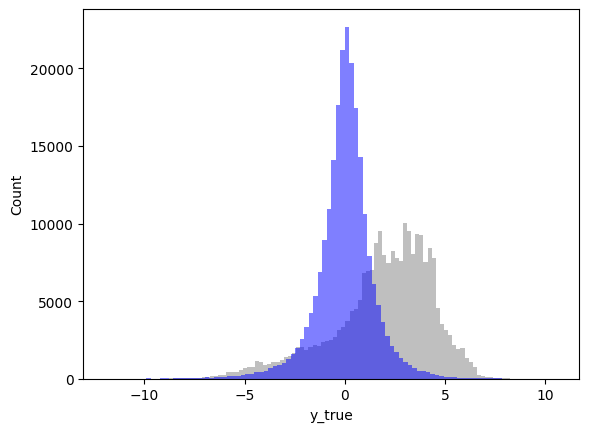

In [76]:
import seaborn as sns
sns.histplot(
    data=results_lco,
    x='y_true',
    color='gray',
    bins=100,
    alpha=0.5,
    edgecolor=None,
    linewidth=0.3,
)
import seaborn as sns
sns.histplot(
    data=results_lco_norm,
    x='y_true',
    color='blue',
    bins=100,
    alpha=0.5,
    edgecolor=None,
    linewidth=0.3,
)


In [44]:
t_vs_p_path = 'to_the_stars/true_vs_pred.csv' if True else 'to_the_universe_new/true_vs_pred.csv'
results = pd.read_csv(t_vs_p_path, dtype={"drug": str, "cell_line": str, "CV_split": int})

In [155]:
# cleaned up version of the code


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def compute_variance_decomposition(y_true, y_pred_rf, y_pred_nm):
    tss = np.var(y_true, ddof=0)
    rss_rf = np.mean((y_true - y_pred_rf) ** 2)
    rss_nm = np.mean((y_true - y_pred_nm) ** 2)
    ess_rf = tss - rss_rf
    ess_nm = tss - rss_nm
    r2_rf = ess_rf / tss
    r2_nm = ess_nm / tss
    extra_ess = ess_rf - ess_nm
    relative_gain = extra_ess / (tss - ess_nm) if (tss - ess_nm) > 0 else 0
    unexplained = tss - ess_rf

    return {
        "tss": tss,
        "ess_nm": ess_nm,
        "ess_rf": ess_rf,
        "extra_ess": extra_ess,
        "unexplained": unexplained,
        "r2_nm": r2_nm,
        "r2_rf": r2_rf,
        "relative_gain": relative_gain
    }

def plot_variance_decomposition(ax, tss, ess_nm, extra_ess, unexplained, max_tss,
                                xlabel=None):
    font_adder = 10
    components = [ess_nm, extra_ess, unexplained]
    colors = ['#999999', '#3355aa', '#cc3333']
    labels = ['Naive', 'RF gain', 'Unexplained']

    ax.bar(0, tss, color='white', edgecolor='black', width=0.6)
    bottom = 0
    for val, label, color in zip(components, labels, colors):
        height = val
        percent = (val / tss) * 100 if tss > 0 else 0
        ax.bar(0, height, bottom=bottom, label=label, color=color, width=0.6)

        text_color = 'white'

        # Add % label if block is tall enough
        if height > 0.03 * max_tss:
            ax.text(0, bottom + height / 2, f"{percent:.1f}%", ha='center', va='center',
                    fontsize=5+font_adder, fontweight='bold', color=text_color)

        bottom += height

    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(0, max_tss * 1.1)
    ax.set_xticks([0])
    ax.set_xticklabels([xlabel] if xlabel else [''])
    ax.set_ylabel("Variance", fontsize=10+font_adder)
    ax.tick_params(axis='both', labelsize=9+font_adder)








def get_model_preds_and_merge(rf_results, nm_results, merge_cols, pred_col_rf='y_pred_rf', pred_col_nm='y_pred_nm'):
    try:
        rf = rf_results[rf_results.CV_split == 0].copy()
        nm = nm_results[nm_results.CV_split == 0].copy()
    except AttributeError:
        rf = rf_results[rf_results.CV_split_x == 0].copy()
        nm = nm_results[nm_results.CV_split_x == 0].copy()

    rf = rf.rename(columns={'y_pred': pred_col_rf})
    nm = nm.rename(columns={'y_pred': pred_col_nm})

    merged = rf.merge(nm[merge_cols + [pred_col_nm]], on=merge_cols, how='inner')
    return merged



In [ ]:

# --- Load raw predictions ---
rf_raw = get_results_and_drug_vis(algorithm="RandomForest", sample=SAMPLE, LCO=True, normalized=False)
nm_raw = get_results_and_drug_vis(algorithm="NaiveMeanEffectsPredictor", sample=SAMPLE, LCO=True, normalized=False)
merged_raw = get_model_preds_and_merge(rf_raw, nm_raw, merge_cols=['drug', 'cell_line'])

# --- Load normalized predictions ---
rf_norm = get_results_and_drug_vis(algorithm="RandomForest", sample=SAMPLE, LCO=True, normalized=True)
nm_norm = get_results_and_drug_vis(algorithm="NaiveMeanEffectsPredictor", sample=SAMPLE, LCO=True, normalized=True)
merged_norm = get_model_preds_and_merge(rf_norm, nm_norm, merge_cols=['drug', 'cell_line'])



[Raw]
Total variance (TSS): 6.2282
Naive Mean R²: 0.6695
Random Forest R²: 0.7511
Extra variance explained by RF (ESS): 0.5080
Relative gain over unexplained variance: 24.68%

[Normalized]
Total variance (TSS): 1.7045
Naive Mean R²: -0.0842
Random Forest R²: 0.2277
Extra variance explained by RF (ESS): 0.5317
Relative gain over unexplained variance: 28.77%


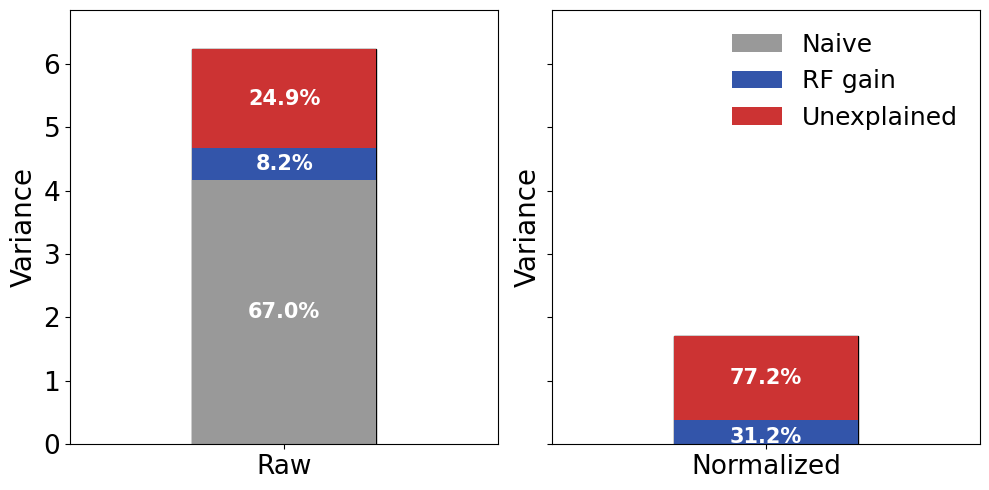

In [ ]:

# --- Compute decompositions ---
raw_metrics = compute_variance_decomposition(
    merged_raw['y_true'].values,
    merged_raw['y_pred_rf'].values,
    merged_raw['y_pred_nm'].values
)

norm_metrics = compute_variance_decomposition(
    merged_norm['y_true'].values,
    merged_norm['y_pred_rf'].values,
    merged_norm['y_pred_nm'].values
)

# --- Print metrics ---
def print_metrics(label, metrics):
    print(f"\n[{label}]")
    print(f"Total variance (TSS): {metrics['tss']:.4f}")
    print(f"Naive Mean R²: {metrics['r2_nm']:.4f}")
    print(f"Random Forest R²: {metrics['r2_rf']:.4f}")
    print(f"Extra variance explained by RF (ESS): {metrics['extra_ess']:.4f}")
    print(f"Relative gain over unexplained variance: {metrics['relative_gain']*100:.2f}%")

print_metrics("Raw", raw_metrics)
print_metrics("Normalized", norm_metrics)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
max_tss = max(raw_metrics['tss'], norm_metrics['tss'])

plot_variance_decomposition(
    ax=axes[0],
    tss=raw_metrics['tss'],
    ess_nm=raw_metrics['ess_nm'],
    extra_ess=raw_metrics['extra_ess'],
    unexplained=raw_metrics['unexplained'],
    max_tss=max_tss,
    xlabel='Raw',

)

plot_variance_decomposition(
    ax=axes[1],
    tss=norm_metrics['tss'],
    ess_nm=norm_metrics['ess_nm'],
    extra_ess=norm_metrics['extra_ess'],
    unexplained=norm_metrics['unexplained'],
    max_tss=max_tss,
    xlabel='Normalized',

)

axes[1].legend(loc='upper right', frameon=False, fontsize=18)
plt.tight_layout()
plt.savefig("figures/variance_decomposition.pdf", bbox_inches='tight')
plt.show()

